# Exercício 1
## Demanda do Especialista do Ministério da Agricultura
- Avaliação do Impacto de Fatores Climáticos na Produção Agrícola


---

Importando bibliotevas necessárias

In [234]:
from hashlib import sha1
from unidecode import unidecode

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

## Dados sobre Grãos

### Lendo dados sobre área plantada

In [4]:
df_planted_area = pd.read_csv(
    filepath_or_buffer='data/raw/grains/planted_area.csv',
    sep=',',
    index_col=0,
)

Transformando tabela de tipo largo para longo

In [5]:
df_planted_area = pd.melt(
    frame=df_planted_area,
    id_vars=['Grain', 'Year'],
    var_name='city',
    value_name='planted_area'
)

Visualizando dados

In [6]:
df_planted_area.tail()

,Grain,Year,city,planted_area
2558975,Pea,2017,Brasília (DF),32.0
2558976,Barley,2018,Brasília (DF),100.0
2558977,Pea,2018,Brasília (DF),40.0
2558978,Barley,2019,Brasília (DF),100.0
2558979,Pea,2019,Brasília (DF),40.0


### Lendo dados sobre área colhida

In [7]:
df_harvested_area = pd.read_csv(
    filepath_or_buffer='data/raw/grains/harvested_area.csv',
    sep=',',
    index_col=0,
)

Transformando tabela de tipo largo para longo

In [8]:
df_harvested_area = pd.melt(
    frame=df_harvested_area,
    id_vars=['Grain', 'Year'],
    var_name='city',
    value_name='harvested_area'
)

Visualizando dados

In [9]:
df_harvested_area.tail()

,Grain,Year,city,harvested_area
2558975,Pea,2017,Brasília (DF),32.0
2558976,Barley,2018,Brasília (DF),100.0
2558977,Pea,2018,Brasília (DF),40.0
2558978,Barley,2019,Brasília (DF),70.0
2558979,Pea,2019,Brasília (DF),40.0


### Lendo dados sobre produtividade

In [173]:
df_yield = pd.read_csv(
    filepath_or_buffer='data/raw/grains/yield.csv',
    sep=',',
    index_col=0,
)

Transformando tabela de tipo largo para longo

In [174]:
df_yield = pd.melt(
    frame=df_yield,
    id_vars=['Grain', 'Year'],
    var_name='city',
    value_name='yield'
)

Visualizando dados

In [175]:
df_yield.tail()

,Grain,Year,city,yield
2558975,Pea,2017,Brasília (DF),7.0
2558976,Barley,2018,Brasília (DF),4.5
2558977,Pea,2018,Brasília (DF),7.0
2558978,Barley,2019,Brasília (DF),4.5
2558979,Pea,2019,Brasília (DF),7.0


### Lendo dados sobre produção

In [10]:
df_production = pd.read_csv(
    filepath_or_buffer='data/raw/grains/production.csv',
    sep=',',
    index_col=0
)

Transformando tabela de tipo largo para longo

In [11]:
df_production = pd.melt(
    frame=df_production,
    id_vars=['Grain', 'Year'],
    var_name='city',
    value_name='production'
)

Visualizando dados

In [12]:
df_production.tail()

,Grain,Year,city,production
2558975,Pea,2017,Brasília (DF),7.0
2558976,Barley,2018,Brasília (DF),4.5
2558977,Pea,2018,Brasília (DF),7.0
2558978,Barley,2019,Brasília (DF),4.5
2558979,Pea,2019,Brasília (DF),7.0


### Realizando cruzamento dos dados

Comparando se dados sobre produção e produtividade são diferentes

In [179]:
df_production['production'].equals(df_yield['yield'])

True

Neste dataset não são, logo podemos ficar com apenas um destes

Realizando mesca entre dados de plantio, colheita e produção

In [17]:
df_plantation = pd.merge(
    left=df_harvested_area,
    right=df_planted_area,
    how='inner',
    on=['Grain', 'Year', 'city']
)

df_plantation = pd.merge(
    left=df_plantation,
    right=df_production,
    how='left',
    on=['Grain', 'Year', 'city']
)

Extraindo unidade federativa do nome da cidade

In [18]:
df_plantation['state'] = df_plantation['city'].str.extract(r'\((\w{2})\)')

Removendo informação de unidade federativa da coluna de cidade e tratando nome de cidades

In [19]:
df_plantation['city'] = df_plantation['city'].str.replace(r'\(\w{2}\)', '', regex=True)
df_plantation['city'] = df_plantation['city'].str.strip()
df_plantation['city'] = df_plantation['city'].map(lambda city: unidecode(city.lower()))

Criando coluna com as regiões do brazil

In [20]:
brazil_regions = {
    'North': ['RO', 'AC', 'AM', 'RR', 'PA', 'AP', 'TO'],
    'Northeast': ['MA', 'PI', 'CE', 'RN', 'PB', 'PE', 'AL', 'SE', 'BA'],
    'Midwest': ['MT', 'MS', 'GO', 'DF'],
    'Southeast': ['MG', 'ES', 'RJ', 'SP'],
    'South': ['PR', 'SC', 'RS']
}

state_to_region = {state: region for region, states in brazil_regions.items() for state in states}

df_plantation['region'] = df_plantation['state'].map(state_to_region)

Criando chave artificial

In [21]:
df_plantation['artificial_key'] = (
    df_plantation['state']
    + df_plantation['city']
    + df_plantation['Grain']
    + df_plantation['Year'].astype(str)
).map(lambda x: sha1(x.encode('utf-8')).hexdigest())

Alterando nome de todas as colunas para _lower case_

In [22]:
df_plantation.columns = df_plantation.columns.map(lambda column: column.lower())

Alterando tipos das colunas

In [23]:
df_plantation = df_plantation.astype({
    'artificial_key': str,
    'region': str,
    'state': str,
    'city': str,
    'grain': str,
    'year': pd.UInt16Dtype(),
    'planted_area': pd.UInt64Dtype(),
    'harvested_area': pd.UInt64Dtype(),
    'production': pd.Float64Dtype(),
})

Alterando ordem das colunas

In [24]:
df_plantation = df_plantation.loc[:, ['artificial_key', 'region', 'state', 'city', 'grain', 'year', 'planted_area', 'harvested_area', 'production']]

Configurando novo índice para tabela

In [25]:
df_plantation.set_index('artificial_key', inplace=True)

Visualizando dados

In [26]:
df_plantation.tail()

,region,state,city,grain,year,planted_area,harvested_area,production
artificial_key,,,,,,,,
625f6e76440b34e39c5fc6e8b6a8bcab1ca5f04e,Midwest,DF,brasilia,Pea,2017,32,32,7.0
2e35bf97dc0e2b4e1bd59bbec0fde362625d5a3d,Midwest,DF,brasilia,Barley,2018,100,100,4.5
3cc26d41fe231b39cc768c4717f3abfdc7484fa2,Midwest,DF,brasilia,Pea,2018,40,40,7.0
da8a4979d4aaf9ed01dbf5b28e086f86d25aaab1,Midwest,DF,brasilia,Barley,2019,100,70,4.5
dee534fccb86bd1e04892bf1104189e932caed33,Midwest,DF,brasilia,Pea,2019,40,40,7.0


Salvando dados em formato .parquet particioando por ano

In [27]:
df_plantation.to_parquet(
    path='data/trusted/grains/plantation',
    engine='pyarrow',
    index=True,
    compression='snappy',
    partition_cols=['year']
)

## Dados metereológicos

Mapeando o caminho de todos os arquivos csv com dados metereológicos

In [151]:
folder_path = './data/raw/environmental'
csv_files = list(map(
    lambda file: f'{folder_path}/{file}',
    os.listdir(folder_path)
))

Criando função para ler metadados sobre a estação meteorológica

In [152]:
def extract_station_info(file_path: str, number_of_lines: int = 9):

    metadata = {}

    with open(file_path) as file:
        
        line_number = 1
        while line_number < 10:
            line = file.readline().strip()
            key, value = line.split(':')
            metadata[key.strip()] = value.strip()
            line_number += 1
    
    return metadata

Lendos todos os arquivos CSV

In [153]:
df_station = pd.DataFrame()
df_meteorology = pd.DataFrame()

for csv_file in csv_files:

    station_metadata = extract_station_info(csv_file)
    df_station_data = pd.DataFrame([station_metadata])
    df_station = pd.concat([df_station, df_station_data])

    df_meteorology_data = pd.read_csv(
        filepath_or_buffer=csv_file,
        sep=';',
        skiprows=10, # ignorar linhas com metadados
        index_col=False,
        usecols=range(7), # coletar apenas as 7 primeiras colunas do CSV,
        decimal=',',
        parse_dates=[0], # convertendo primeira coluna para tipo date
        dtype={ 1: pd.UInt16Dtype() } # convertendo segunda coluna para int
    )

    df_meteorology_data['station_code'] = station_metadata['Codigo Estacao']
    df_meteorology = pd.concat([df_meteorology, df_meteorology_data])

In [154]:
df_station[['city', 'sub_region']] = df_station['Nome'].str.split(
    pat='-',
    n=1,
    expand=True
)

Corrigindo algumas exceções

In [ ]:
paranoa_index = df_station['Nome'] == 'PARANOA (COOPA-DF)'
df_station['city'][paranoa_index] = 'PARANOA'
df_station['sub_region'][paranoa_index] = None

guarda_mor_index = df_station['Nome'] == 'GUARDA-MOR'
df_station['city'][guarda_mor_index] = 'GUARDA-MOR'
df_station['sub_region'][guarda_mor_index] = None

Tratando nomes de cidades e regiões

In [156]:
df_station['city'] = df_station['city'].map(lambda city: unidecode(city.lower()))
df_station['sub_region'] = df_station['sub_region'].map(lambda sub_region: unidecode(sub_region.lower()) if sub_region else None)

In [157]:
df_station.rename(
    inplace=True,
    columns={
        'Codigo Estacao': 'station_code',
        'Latitude': 'latitude',
        'Longitude': 'longitude',
        'Altitude': 'altitude',
        'Situacao': 'operational_condition',
        'Data Inicial': 'initial_date',
        'Data Final': 'final_date',
        'Periodicidade da Medicao': 'measurement_frequency',
    }
)

In [158]:
df_station = df_station.astype({
    'station_code': str,
    'latitude': 'Float64',
    'longitude': 'Float64',
    'altitude': 'Float64',
    'initial_date': 'datetime64[ns]',
    'final_date': 'datetime64[ns]',
})

In [159]:
df_station.drop(columns=['Nome'], inplace=True)

In [160]:
df_station.tail()

,station_code,latitude,longitude,altitude,operational_condition,initial_date,final_date,measurement_frequency,city,sub_region
0,A944,-14.828889,-56.441944,195.0,Operante,2019-05-29,2019-12-31,Mensal,rosario oeste,None
0,B803,-24.570833,-52.800278,598.0,Operante,2016-08-03,2019-12-31,Mensal,campina da lagoa,None
0,B804,-25.371389,-52.400833,889.0,Operante,2016-08-06,2019-12-31,Mensal,laranjeiras do sul,None
0,B806,-25.322464,-49.157733,950.0,Operante,2016-05-31,2019-12-31,Mensal,colombo,None
0,F501,-19.98,-43.958611,1199.55,Operante,2013-12-26,2019-12-31,Mensal,belo horizonte,cercadinho


In [161]:
df_station.to_parquet(
    path='data/trusted/environmental/station.parquet.snappy',
    engine='pyarrow',
    index=True,
    compression='snappy',
)

In [162]:
df_meteorology.rename(
    inplace=True,
    columns={
        'Data Medicao': 'measurement_date',
        'NUMERO DE DIAS COM PRECIP. PLUV, MENSAL (AUT)(número)': 'number_of_rainy_days',
        'PRECIPITACAO TOTAL, MENSAL (AUT)(mm)': 'total_precipitation',
        'PRESSAO ATMOSFERICA, MEDIA MENSAL (AUT)(mB)': 'atmospheric_pressure',
        'TEMPERATURA MEDIA, MENSAL (AUT)(°C)': 'average_temperature',
        'VENTO, VELOCIDADE MAXIMA MENSAL (AUT)(m/s)': 'maximum_wind_speed',
        'VENTO, VELOCIDADE MEDIA MENSAL (AUT)(m/s)': 'average_wind_speed',
    }
)

Agrupando dados por estação metereológica e por ano

In [163]:
df_meteorology['year'] = df_meteorology['measurement_date'].dt.year

In [164]:
group = df_meteorology.groupby(by=['station_code', 'year'])

In [165]:
sum_aggregations = group[['number_of_rainy_days', 'total_precipitation']].sum()
mean_aggregations = group[['atmospheric_pressure', 'average_temperature', 'average_wind_speed']].mean()
max_aggregations = group[['maximum_wind_speed']].max()

In [166]:
df_annual_meteorology = sum_aggregations \
    .merge(mean_aggregations, left_index=True, right_index=True) \
    .merge(max_aggregations, left_index=True, right_index=True)

In [167]:
df_annual_meteorology.reset_index(inplace=True)

In [168]:
df_annual_meteorology.tail()

,station_code,year,number_of_rainy_days,total_precipitation,atmospheric_pressure,average_temperature,average_wind_speed,maximum_wind_speed
6686,F501,2015,115,1343.8,883.141667,20.316667,5.391667,16.2
6687,F501,2016,112,1492.2,883.033333,20.066667,5.241667,16.7
6688,F501,2017,92,1237.8,883.275000,19.366667,5.575000,17.5
6689,F501,2018,138,1683.2,882.816667,19.591667,5.125000,17.6
6690,F501,2019,105,1211.4,883.200000,20.341667,5.275000,17.1


In [169]:
df_annual_meteorology.to_parquet(
    path='data/trusted/environmental/meteorology.parquet.snappy',
    engine='pyarrow',
    index=False,
    compression='snappy',
)

## Cruzamento de dados

In [222]:
df_station_meteorology = df_station.merge(df_annual_meteorology, on='station_code', how='inner')

In [223]:
group_station_meteorology = df_station_meteorology.groupby(by=['city', 'year'])

sum_aggregations = group_station_meteorology[['number_of_rainy_days', 'total_precipitation']].sum()
mean_aggregations = group_station_meteorology[['atmospheric_pressure', 'average_temperature', 'average_wind_speed']].mean()
max_aggregations = group_station_meteorology[['maximum_wind_speed']].max()

In [224]:
df_station_meteorology_per_city = sum_aggregations \
    .merge(mean_aggregations, left_index=True, right_index=True) \
    .merge(max_aggregations, left_index=True, right_index=True)

In [225]:
df_station_meteorology_per_city.reset_index(inplace=True)

In [226]:
df_environment_impact = df_plantation.merge(
    df_station_meteorology_per_city,
    how='inner',
    on=['city', 'year'],
)

Removendo cidades que não tiveram plantação

In [227]:
zero_planted_search = df_environment_impact['planted_area'] == 0
zero_planted_search_indexes = df_environment_impact[zero_planted_search].index
df_environment_impact.drop(index=zero_planted_search_indexes, inplace=True)

Preenchendo dados de produção com 0 em condições onde não se colheu nada

In [228]:
nan_prod_search = (df_environment_impact['production'].isna()) & (df_environment_impact['harvested_area'] == 0)
df_environment_impact.loc[nan_prod_search, 'production'] = 0

In [233]:
df_environment_impact.tail()

,region,state,city,grain,year,planted_area,harvested_area,production,number_of_rainy_days,total_precipitation,atmospheric_pressure,average_temperature,average_wind_speed,maximum_wind_speed
66645,Midwest,DF,brasilia,Pea,2017,32,32,7.0,117,1291.8,887.691667,21.458333,2.391667,9.1
66646,Midwest,DF,brasilia,Barley,2018,100,100,4.5,131,1668.6,887.566667,21.241667,2.200000,7.1
66647,Midwest,DF,brasilia,Pea,2018,40,40,7.0,131,1668.6,887.566667,21.241667,2.200000,7.1
66648,Midwest,DF,brasilia,Barley,2019,100,70,4.5,120,1394.0,887.866667,21.958333,2.200000,7.3
66649,Midwest,DF,brasilia,Pea,2019,40,40,7.0,120,1394.0,887.866667,21.958333,2.200000,7.3


## Análise Exploratória

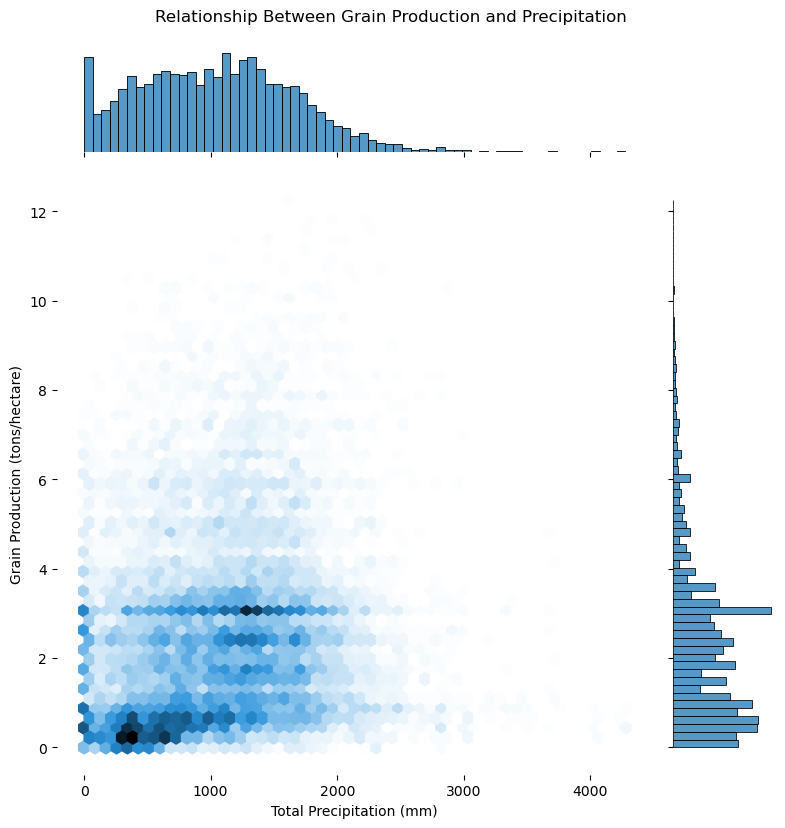

In [240]:
sns.jointplot(
   data=df_environment_impact,
   y='production',
   x='total_precipitation',
   kind='hex',
   height=8,
)

plt.xlabel('Total Precipitation (mm)')
plt.ylabel('Grain Production (tons/hectare)')
plt.suptitle('Relationship Between Grain Production and Precipitation', y=1.03)

sns.despine(left=True, bottom=True)

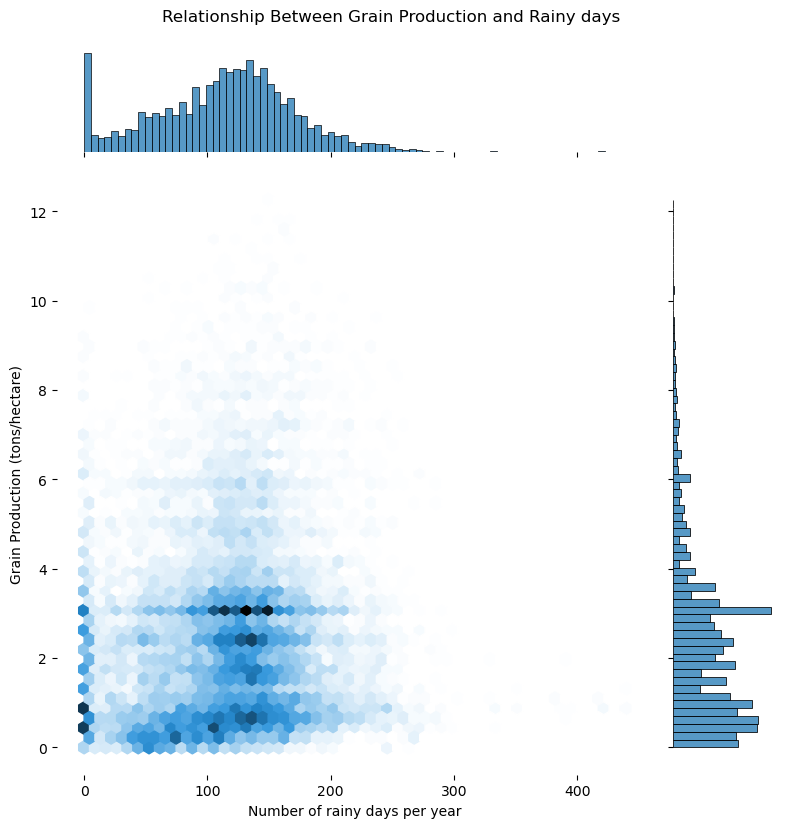

In [239]:
sns.jointplot(
   data=df_environment_impact,
   y='production',
   x='number_of_rainy_days',
   kind='hex',
   height=8,
)

plt.xlabel('Number of rainy days per year')
plt.ylabel('Grain Production (tons/hectare)')
plt.suptitle('Relationship Between Grain Production and Rainy days', y=1.03)

sns.despine(left=True, bottom=True)

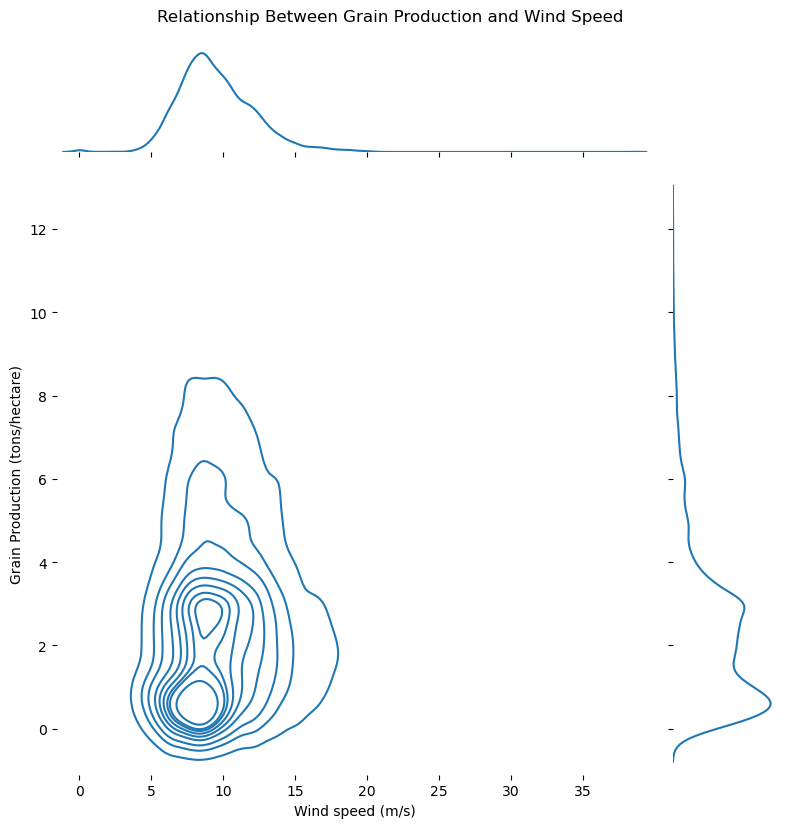

In [237]:
sns.jointplot(
   data=df_environment_impact,
   y='production',
   x='maximum_wind_speed',
   kind='kde',
   height=8,
)

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Grain Production (tons/hectare)')
plt.suptitle('Relationship Between Grain Production and Wind Speed', y=1.03)

sns.despine(left=True, bottom=True)